It has been suggested by Nick that I can compute a Fischer Forecast with the VDF by just doing finite different around each point in the parameter space. Gonna try to do that here. 

In [326]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set()

In [327]:
from pearce.emulator import LemonPepperWet, NashvilleHot
import numpy as np
from os import path
import h5py
from copy import deepcopy
from scipy.linalg import inv

In [328]:
fd_vdf= np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/fd_vdf_vals.npy')
fd_xi = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/fd_xi_vals.npy')

In [329]:
fd_dvdf = fd_vdf[:,:,:,20:]
fd_vdf = fd_vdf[:,:,:,:20]

In [330]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [331]:
pnames = ['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [332]:
pbounds = [(-1.0, 1.0),
 (12.6, 13.6),
 (0.05, 0.5),
 (-1.0, 1.0),
 (13.7, 14.7),
 (0.7, 1.3),
 (0.5, 2.0)]

In [333]:
rbc = np.array([ 0.57715889,  0.7521343 ,  0.98015643,  1.27730729,  1.66454443,
        2.16917901,  2.82680202,  3.68379447,  4.80059857,  6.25598058,
        8.15258606, 10.62417931, 13.84507753, 18.04244507, 23.51231502,
       30.64046783, 39.92963975, 52.03497999, 67.81025724, 88.36807447])

In [334]:
rmin = 0.0
bin_idxs = rbc>rmin
rbc = rbc[bin_idxs]

In [335]:
fd_vdf = fd_vdf[:,:,:,bin_idxs]
fd_dvdf = fd_dvdf[:,:,:,bin_idxs]
fd_xi = fd_xi[:,:,:,bin_idxs]

In [336]:
step_sizes = np.zeros((len(pnames), ))
for i, (name, bound) in enumerate(zip(pnames, pbounds)):
    hod = deepcopy(fiducial_hod)
    step_size = (bound[1]-bound[0])/10
    vals = (hod[name]-step_size, hod[name]+step_size)
    step_sizes[i] = step_size

In [337]:
def deriv(fd_vals, step_sizes):
    avg_vals = fd_vals.mean(axis=2)
    deriv = (avg_vals[:, 1] - avg_vals[:,0]).T/(2*step_sizes)
    return deriv.T

In [338]:
d_xi = deriv(fd_xi, step_sizes)
d_vpf =d_vdf = deriv(fd_vdf, step_sizes)
d_dvpf = deriv(fd_dvdf, step_sizes)

In [339]:
vdf_mean = fd_vdf.mean(axis=(0,1,2))
dvdf_mean = fd_dvdf.mean(axis=(0,1,2))

xi_mean = fd_xi.mean(axis=(0,1,2))

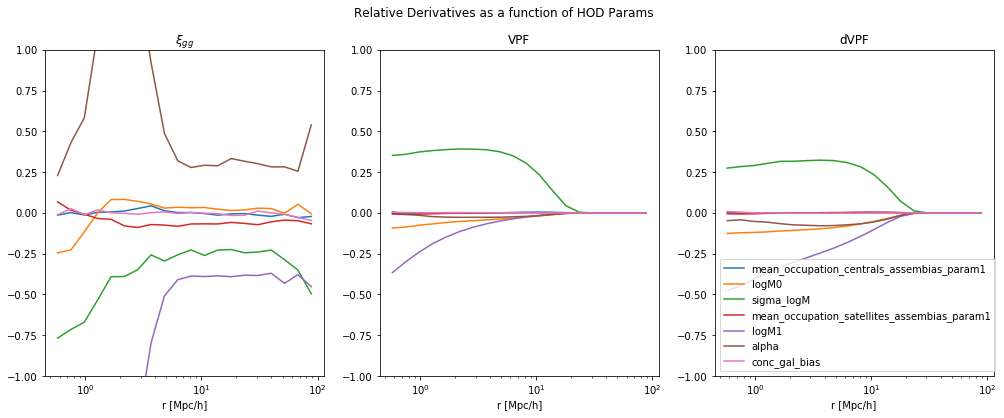

In [340]:
fig = plt.figure(figsize=(17,6))
for i, name in enumerate(pnames):
    plt.subplot(131)
    plt.title(r'$\xi_{gg}$')
    plt.plot(rbc, d_xi[i]/xi_mean)
    plt.xscale('log')
    plt.ylim([-1.0, 1.0])
    plt.xlabel('r [Mpc/h]')

    plt.subplot(132)
    plt.title(r'VPF')

    plt.xscale('log')
    plt.xlabel('r [Mpc/h]')
    plt.plot(rbc, d_vpf[i]/vdf_mean, label = name)
    plt.ylim([-1.0, 1.0])
    
    plt.subplot(133)
    plt.title(r'dVPF')

    plt.xscale('log')
    plt.xlabel('r [Mpc/h]')
    plt.plot(rbc, d_dvpf[i]/dvdf_mean, label = name)
    plt.ylim([-1.0, 1.0])
    
plt.suptitle('Relative Derivatives as a function of HOD Params')
plt.legend(loc='best')

In [341]:
def cholesky_inv(covmat):
    c = inv(cholesky(vdf_fischer_mat))
    return np.dot(c.T, c)

In [342]:
vdf_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/vdf_covmat.npy')#[5:13][:,5:13]#[:2][:,:2]
xi_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/xi_covmat.npy')#[:2][:,:2]

#vdf_covmat+=np.diag(np.ones(vdf_covmat.shape[0]))*1e-3
#xi_covmat-=np.diag(np.ones(xi_covmat.shape[0]))*1e-12

In [343]:
dvdf_covmat = vdf_covmat[20:][:,20:]
vdf_covmat = vdf_covmat[:20][:,:20]

In [344]:
vdf_covmat = vdf_covmat[bin_idxs][:, bin_idxs]
dvdf_covmat = dvdf_covmat[bin_idxs][:, bin_idxs]
xi_covmat = xi_covmat[bin_idxs][:, bin_idxs]

In [345]:
inv_vdf_covmat = inv(vdf_covmat)
inv_dvdf_covmat = inv(dvdf_covmat)

inv_xi_covmat = inv(xi_covmat)

In [346]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

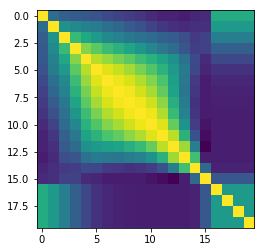

In [347]:
plt.imshow(cov_to_corr(vdf_covmat))

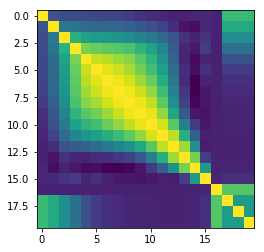

In [348]:
plt.imshow(cov_to_corr(dvdf_covmat))

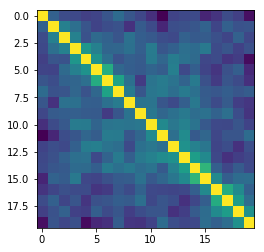

In [349]:
plt.imshow(cov_to_corr(xi_covmat))

In [350]:
d_vdf = d_vdf#[:6]
d_dvpf = d_dvpf#[:6]
d_xi = d_xi#[:6]

In [351]:
vdf_fischer_mat = np.dot(d_vdf, np.dot(inv_vdf_covmat, d_vdf.T))
dvdf_fischer_mat = np.dot(d_dvpf, np.dot(inv_dvdf_covmat, d_dvpf.T))

xi_fischer_mat = np.dot(d_xi, np.dot(inv_xi_covmat, d_xi.T))

vdf_info_mat =inv(vdf_fischer_mat)
dvdf_info_mat =inv(dvdf_fischer_mat)
xi_info_mat = inv(xi_fischer_mat)

In [352]:
# joint constraint
d_all = np.c_[d_vdf, d_dvpf, d_xi]
from scipy.linalg import block_diag
full_covmat = block_diag(vdf_covmat, dvdf_covmat, xi_covmat) + np.diag(np.ones(vdf_covmat.shape[0]*3,))*1e-11
#full_covmat = block_diag(vdf_covmat, dvdf_covmat) + np.diag(np.ones(40,))*1e-11

full_fischer_mat = np.dot(d_all, np.dot(inv(full_covmat), d_all.T))
full_info_mat = inv(full_fischer_mat)

In [353]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [354]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def ellipse_plot(inv_fisher, mean_x, mean_y, xname, yname, fig, ax, lab, co, scale=False):
    #alpha paramaters for 1 and 2 sigma contours
    #alpha1 = 1.52
    #alpha2 = 2.48
    #extracting relevant params from the input inverse fisher matrix
    sigma_x2 = inv_fisher[0][0]
    sigma_y2 = inv_fisher[1][1]
    sigma_xy = inv_fisher[0][1]
    
    pearson = sigma_xy/np.sqrt(sigma_y2 * sigma_x2)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    a2 = 2*np.sqrt(1 + pearson)
    b2 = 2*np.sqrt(1 - pearson)
    
    
    #plotting 1 and 2 sigma contours
    #print mean_x, mean_y
    ell = Ellipse(xy = [0, 0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.5, fill=True, label=lab, color=co)
    ell2 = Ellipse(xy = [0,0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.35, fill=True,  color=co)

    scales = np.sqrt(np.diag(inv_fisher)) #* n_std


    transf1 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0], scales[1]).translate(mean_x, mean_y) \
        
    transf2 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0]*2, scales[1]*2).translate(mean_x, mean_y) \
        
    ell.set_transform(transf1 + ax.transData)
    ell2.set_transform(transf2 + ax.transData)

    #adding patches, axis names, etc
    ax.add_patch(ell)
    ax.add_patch(ell2)
    #ax.set_aspect('equal')
    if scale:
        #ax.autoscale()
        n = 3

        sx, sy = np.sqrt(sigma_x2), np.sqrt(sigma_y2)
        ax.set_xlim([mean_x-n*sx, mean_x+n*sx])
        ax.set_ylim([mean_y-n*sy, mean_y+n*sy])
        if xname =='mean_occupation_centrals_assembias_param1':
            xname = 'A_cen'
        elif xname == 'mean_occupation_satellites_assembias_param1':
            xname = 'A_sat'
            
        if yname =='mean_occupation_centrals_assembias_param1':
            yname = 'A_cen'
        elif yname == 'mean_occupation_satellites_assembias_param1':
            yname = 'A_sat'
            
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)

In [355]:
from scipy.stats import norm

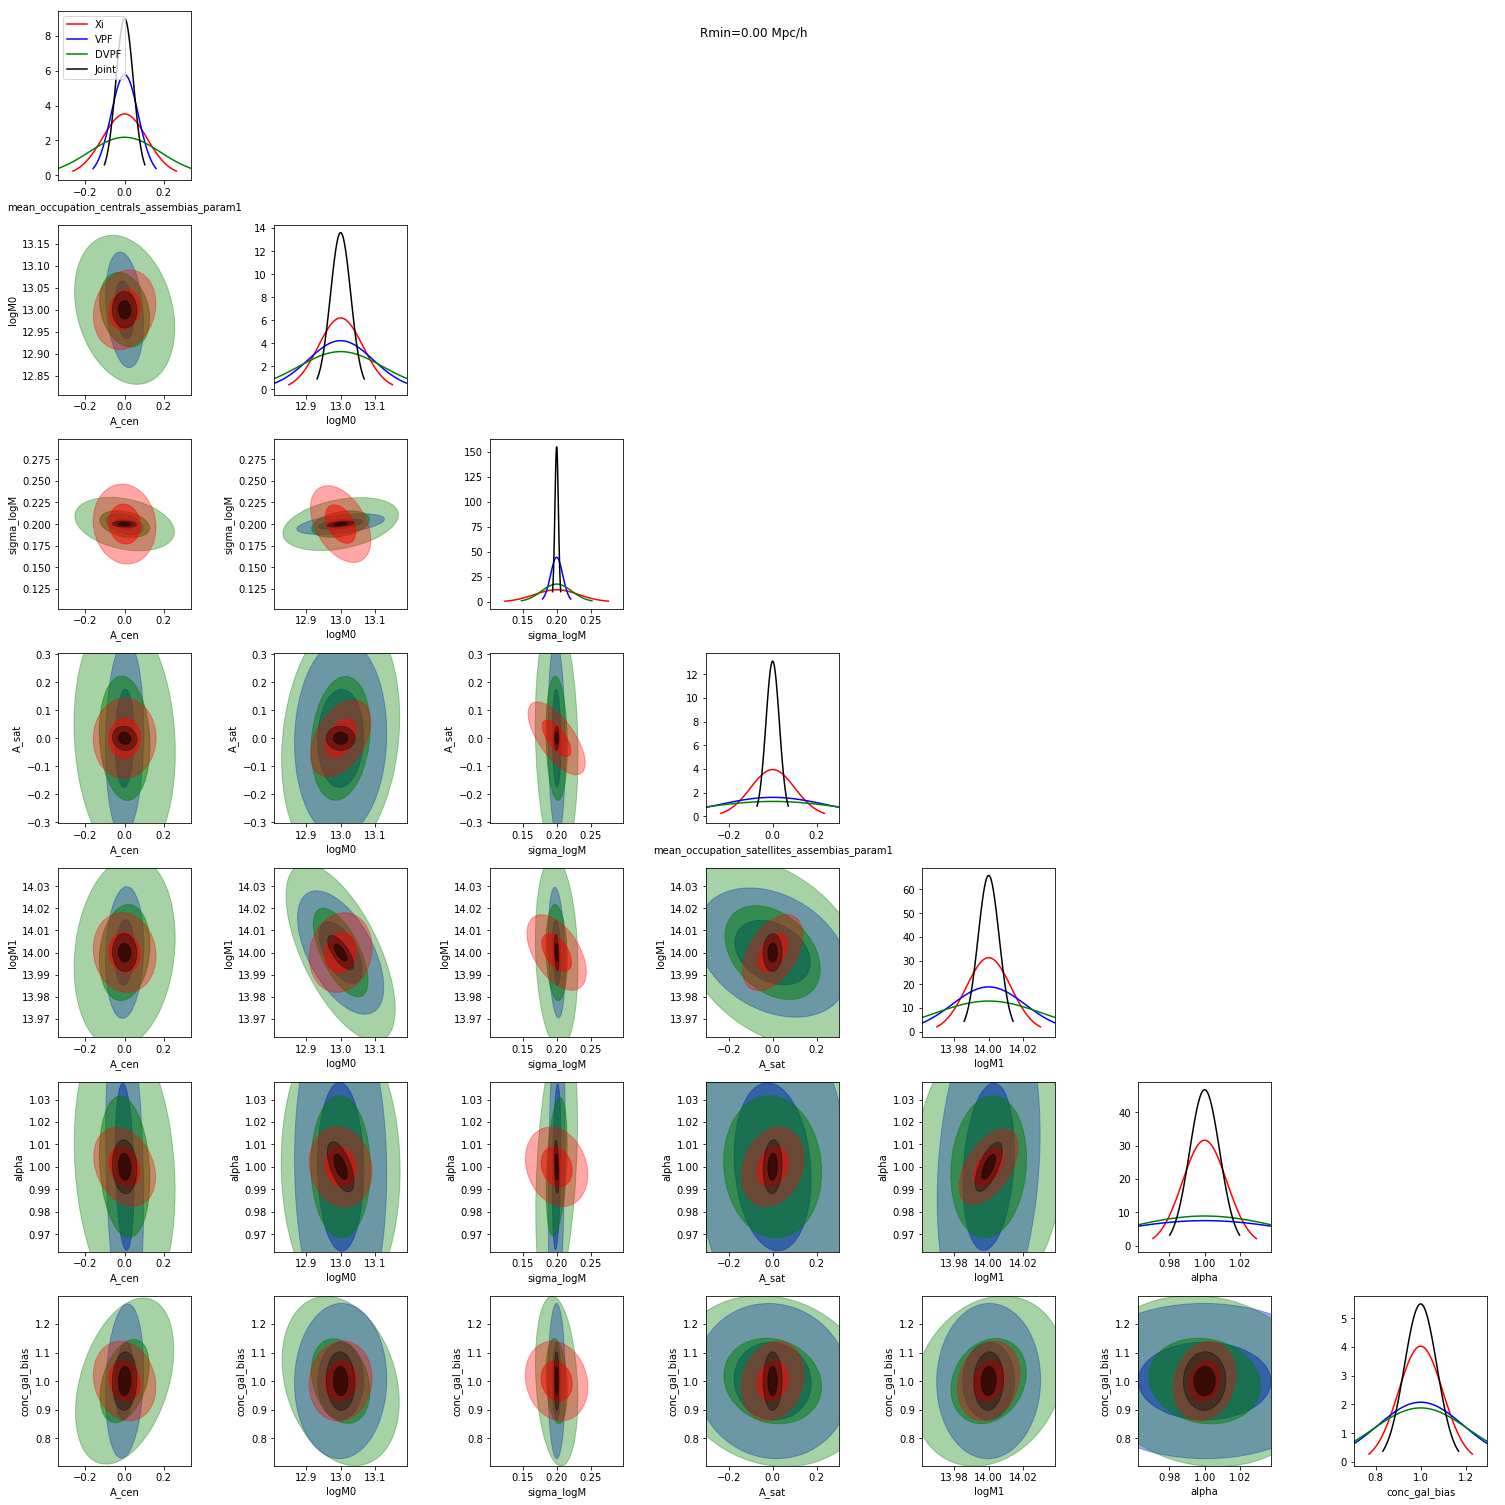

In [356]:
N = d_vdf.shape[0]
size = N*3

fig, axes = plt.subplots(ncols=N, nrows=N, figsize=((size,size)), facecolor='w')

for i, name1 in enumerate(pnames[:N]):
    for j, name2 in enumerate(pnames[:N]):
        if i<j:
            axes[i][j].axis('off')
        elif j == i:
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(xi_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'r', label = 'Xi')

            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(vdf_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'b', label ='VPF')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(dvdf_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'g', label ='DVPF')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(full_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'k', label ='Joint')
        
            axes[i][j].set_xlabel(name2)
            #axes[i][j].autoscale()
            sx = np.sqrt(xi_info_mat[i,i])
            #print name2, fiducial_hod[name2], sx
            #print name2, fiducial_hod[name2]-5*sx, fiducial_hod[name2]+5*sx
            axes[i][j].set_xlim([fiducial_hod[name2]-3*sx, fiducial_hod[name2]+3*sx])
            if i == 0:
                axes[i][j].legend(loc='upper left')

        else:
            #print vdf_info_mat[np.ix_([i,j],[i,j])]
            #print vdf_info_mat[np.ix_([j,i],[j,i])]
            ellipse_plot(vdf_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'b', lab='VDF', scale=False)
            ellipse_plot(dvdf_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'g', lab='DVDF', scale=False)
            ellipse_plot(xi_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'r', lab = 'Xi', scale=True)
            ellipse_plot(full_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'k', lab = 'Joint', scale=False)
            #print '*'*20
plt.suptitle('Rmin=%0.2f Mpc/h'%rmin)
fig.tight_layout()

In [357]:
from scipy.stats import multivariate_normal

In [358]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']